In [ ]:
!pip install pyprind

In [ ]:
import pandas as pd

df = pd.read_excel(io = './IssueReport.xls', sheet_name = 'Raw')
df = df[['SR NUMBER', 'SR DESCRIPTION']]
df_row_count = len(df.index)

df.head(5)

In [ ]:
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

porter = PorterStemmer()
nltk.download('stopwords')
stop = stopwords.words('english')

def preprocessor_marks(text, regexp, encoded_marks):
    marks = re.findall(regexp, text)
    marks = [re.sub(regexp, encoded_marks, w) for w in marks]    
    marks = ' '.join(marks)
    return ' ' + marks + ' '

def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    multipleQuestionMarks = preprocessor_marks(text, '\?\?+', '??')
    multipleExcalamationMarks = preprocessor_marks(text, '\!\!+', '!!')
    text = re.sub('[\W]+', ' ', text.lower())
    text = re.sub('[0-9]', '', text)
    text = text + ''.join(emoticons).replace('-', '')
    text = text + multipleQuestionMarks
    text = text + multipleExcalamationMarks
    text = tokenizer_porter(text)
    text = [w for w in text if w not in stop]
    text = ' '.join(text)
    return text

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [4]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

tfid_vectorizer_vocabulary = {
    'fail': 0,
    'critic': 1,
    'block': 2,
    'error': 3,
    'delay': 4,
    'stuck': 5,
    'wrong': 6,
    '??': 7,
    '!!': 8
}

def tfid_vectorizer(max_features):
    return TfidfVectorizer(max_features = max_features,
                           use_idf = False, vocabulary = tfid_vectorizer_vocabulary, preprocessor = preprocessor);

def execute_clustering(X, n_clusters):
    return KMeans(n_clusters = n_clusters, init='k-means++', max_iter=1000, n_init=1000).fit(X)

In [5]:
max_features = 8

vectorizer = tfid_vectorizer(max_features)
X = vectorizer.transform(df['SR DESCRIPTION']);

n_clusters = 1
kmeans = execute_clustering(X, n_clusters)

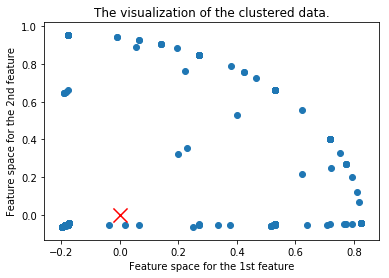

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2).fit(X.todense())

data2D = pca.transform(X.todense())
centers2D = pca.transform(kmeans.cluster_centers_)

plt.title("The visualization of the clustered data.")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")

plt.scatter(data2D[:,0], data2D[:,1])
plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3, c='r')
plt.show()

In [7]:
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(n_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :max_features]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: error fail wrong block delay critic stuck !!


In [ ]:
from scipy.spatial import distance

cluster_center = kmeans.cluster_centers_[0]
data_points = X.todense()

distances = [distance.euclidean(cluster_center, data_point) for data_point in data_points]

df['NEG_DIST'] = distances
df.head()

In [9]:
df.to_excel('./IssueReport_KMeans_Neg.xls')